<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/shruti-working/zindi_airstrip_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [1]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert
!pip -q install segmentation-models-pytorch

In [57]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import rasterio.mask
from shapely.geometry import box
from pyproj import Transformer

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'zindi-amazon-secret-runway'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 243 (delta 32), reused 6 (delta 2), pack-reused 162 (from 1)
Receiving objects: 100% (243/243), 14.83 MiB | 18.77 MiB/s, done.
Resolving deltas: 100% (99/99), done.
fatal: not a git repository (or any of the parent directories): .git


### Authenticate Google Earth Engine

In [5]:
ee.Authenticate()
ee.Initialize(project="ee-runway-detection")

<a name="aoi-bounds"></a>
# Download AOI Boundaries

Our first step is to download the AOIs.

In [6]:
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'
aoi_name = 'aoi_2020_01'

# Select export folder on Google Drive
export_folder = 'Colab Notebooks'

In [7]:
# Read data using GeoPandas
filename = os.path.join(base_aoi_path, f'{aoi_name}.shp')
aoiboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(aoiboundary.shape))
aoiboundary

Data dimensions: (1, 11)


MINX          MINY           MAXX          MAXY           CNTX  \
0  690096.799317  8.793048e+06  705506.799317  8.808318e+06  697801.799317   

           CNTY         AREA    PERIM   HEIGHT    WIDTH  \
0  8.800683e+06  235310700.0  61360.0  15270.0  15410.0   

                                            geometry  
0  POLYGON ((690096.799 8793048.011, 690096.799 8...

In [8]:
# Plot the boundary
fig, ax = plt.subplots(1, figsize=(10,10))
aoiboundary.plot(ax=ax);

<a name="sentinel-2"></a>
# Download Sentinel-2 Satellite Image for AOI

In [9]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

We generate and visualize the Sentinel-2 satellite image for AOI. The satellite image is generated by getting the median of all Sentinel-2 images in 2020 with a cloud cover of less than 10%.

In [10]:
# Get the shape geometry for AOI
aoiboundary_4326 = aoiboundary.to_crs(epsg=4326)
region  = aoiboundary_4326
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

year = 2020 #TODO: Extract from AOI name & use in min_date & max_date

aoicrs = aoiboundary.crs.to_string()

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2_SR_HARMONIZED', # Sentinel-2A
    min_date='2020-01-01', # Get all images within
    max_date='2020-12-31', # the year 2020
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Export Image to Local Gdrive
In the following cell, we define a function to export our generated Sentinel-2 satellite image to our local Google Drive.

In [11]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs=aoicrs,
      maxPixels=900000000
    )
    task.start()

    return task

We can now proceed to download the image to our local Google Drive as a GeoTIFF.

**Note**: Be careful about exporting large images as they can take a while to download and could eat up storage space!

In [12]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, aoi_name, region, folder)

Exporting to aoi_2020_01.tif ...


You can repeatedly run `task.status()` to monitor the state of the task. After a while, the state should change from "READY" to "RUNNING" to "COMPLETE".

Alternatively, you can go to https://code.earthengine.google.com/ to check the status of the task.

In [20]:
task.status()

{'state': 'COMPLETED',
 'description': 'aoi_2020_01',
 'priority': 100,
 'creation_timestamp_ms': 1729962516583,
 'update_timestamp_ms': 1729962591631,
 'start_timestamp_ms': 1729962531689,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1gzWdVPxDnWmqLgUnLdNvD-1mKF4uW71_'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 78.42806243896484,
 'id': 'XO6JH4ZSC2RMTD7VDHUYLYIC',
 'name': 'projects/ee-runway-detection/operations/XO6JH4ZSC2RMTD7VDHUYLYIC'}

## Visualize Sentinel-2A Image

Once the task status changes to "COMPLETE", check that the satellite image is in your google drive.

In the following cell, we load and visualize the satellite raster image using the Rasterio library.

In [21]:
# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(aoi_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(aoi_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Open image file using Rasterio
image = rio.open(tif_file)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
aoiboundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generate 224x224 px GeoJSON Tiles

Let's start by creating a function that generates a grid of 224px X 224px square polygons using [Rasterio Window utilities](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [22]:
def generate_tiles(image_file, output_file, area_str, size=224):
    """Generates 224 x 224 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 224 x 224 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 224 x 224 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to AOI crs
    results.crs = {'init' : aoicrs}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 224x224 px across the Sentinel-2 satellite image.

In [23]:
output_file = os.path.join(cwd, '{}.geojson'.format(aoi_name))
tiles = generate_tiles(tif_file, output_file, aoi_name, size=224)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(aoi_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/2356176 [00:00<?, ?it/s]

Data dimensions: (49, 2)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id                                           geometry
0  aoi_2020_01-0  POLYGON ((692330 8806080, 692330 8808320, 6900...
1  aoi_2020_01-1  POLYGON ((694570 8806080, 694570 8808320, 6923...
2  aoi_2020_01-2  POLYGON ((696810 8806080, 696810 8808320, 6945...

## Visualize 224x224 px Tiles

Let's open the Sentinel-2 raster file using Rasterio and superimpose the 224x224px vector polygons as follows.

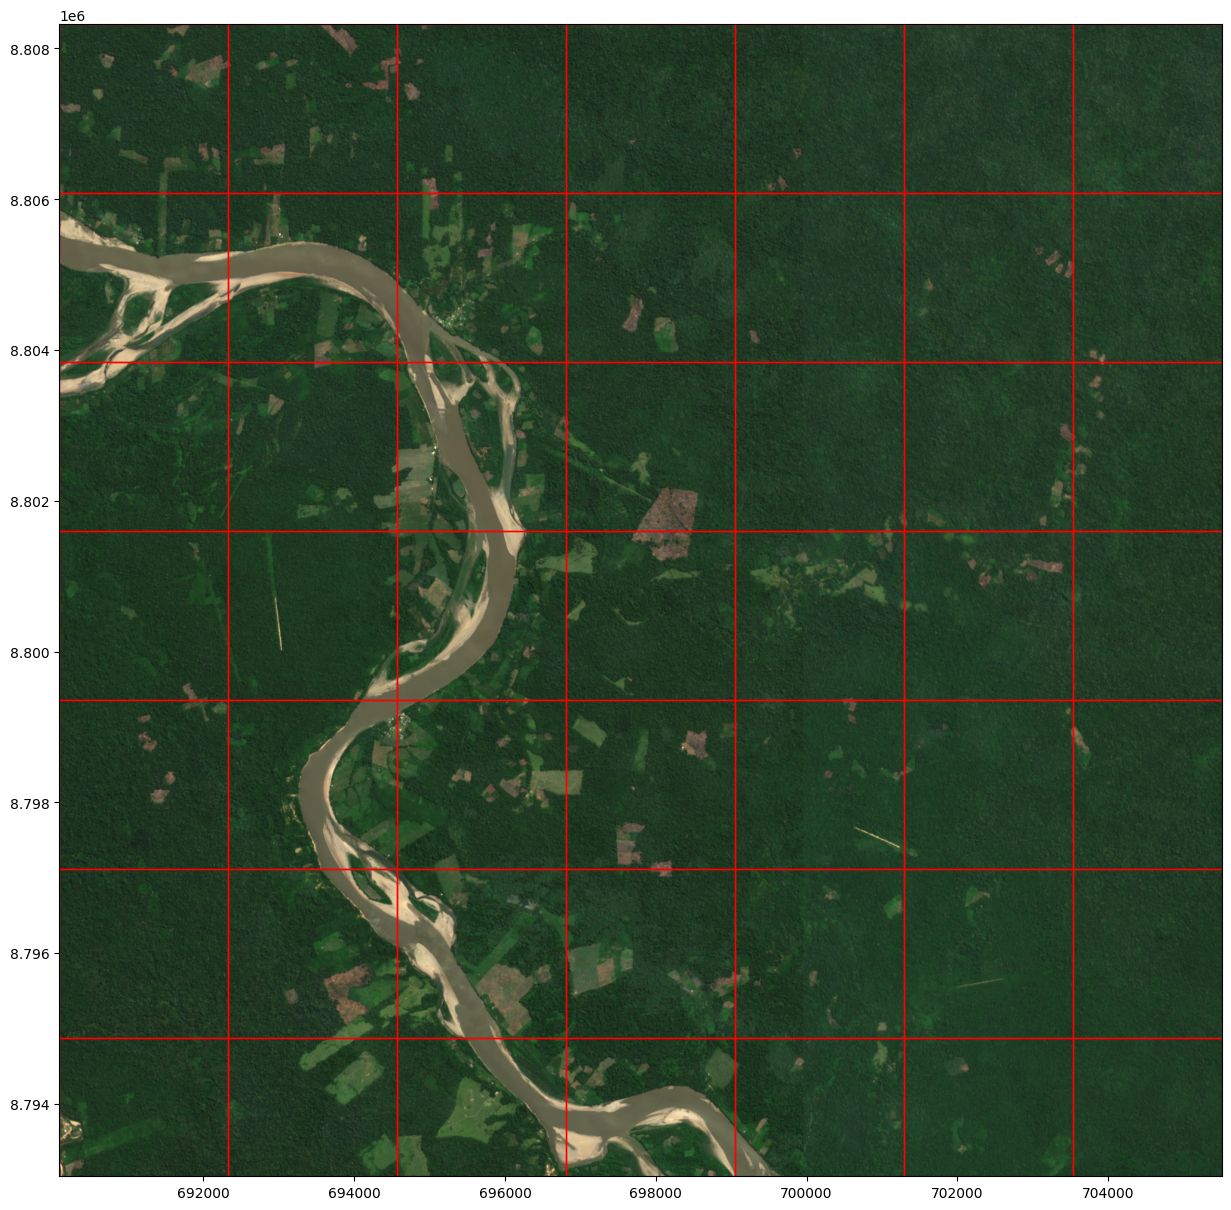

In [24]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="lulc-maps"></a>
# Inference
In this section, we will generate airstrip prediction using the trained model from the previous tutorial.

## Load trained Model
First, load your trained model.

In [29]:
# UNet model with ResNet50 encoder
def get_model():
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=3,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = '/content/drive/MyDrive/Zindi-Amazon/models/' +'zindi_best_model_20241022.pth'

# Uncomment this to download the model file
if not os.path.isfile(model_file):
  model_file = 'zindi_best_model_20241022.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = get_model().to(device)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]
<ipython-input-30-011be8951c40>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

Model file /content/drive/MyDrive/Zindi-Amazon/models/zindi_best_model_20241022.pth successfully loaded.


Remember in the previous tutorial that we applied a set of data transformations to our test set. Before we run our new images through the model, we'll need to apply these same transformation to our new data as follow.

In [31]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Model Prediction & LULC Map Generation

Next, let's define a function that:
1. Crops the source image using the 224x224 tile geometry
2. Generates a prediction for the cropped image using the trained model

(3, 223, 223)


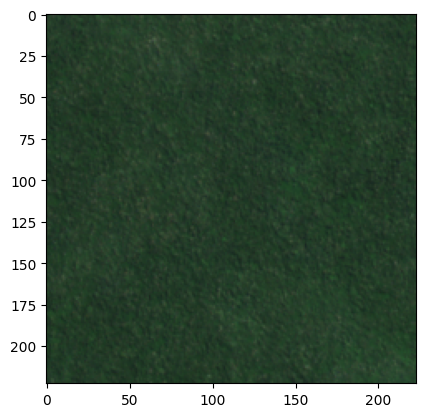

In [40]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      print(out_image.shape)
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

In [49]:
def predict_crop(image, shape, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)

        # Get the model's output
        output = model(input.unsqueeze(0))

        # Apply sigmoid if necessary to get probabilities between 0 and 1
        # output = torch.sigmoid(output) # Uncomment if model outputs logits instead of probabilities

        # Threshold to get binary predictions (0 or 1)
        predictions = (output > 0.5).int() # Adjust threshold if needed

        # Return the entire prediction tensor
        return predictions

    return None

Let's iterate over every 224x224 px tile and generate model predictions for the corresponding cropped image. Note that we are overwriting each temporary TIFF file to save storage space.

In [51]:
# Commence model prediction
all_predictions = []  # Store predictions for all tiles
for index in tqdm(range(len(tiles)), total=len(tiles)):
    predictions = predict_crop(tif_file, [tiles.iloc[index]['geometry']], model)
    all_predictions.append(predictions)

# Save predictions
filepath = os.path.join(cwd, "{}_preds.geojson".format(aoi_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/49 [00:00<?, ?it/s]

id                                           geometry  \
0  aoi_2020_01-0  POLYGON ((692330 8806080, 692330 8808320, 6900...   
1  aoi_2020_01-1  POLYGON ((694570 8806080, 694570 8808320, 6923...   
2  aoi_2020_01-2  POLYGON ((696810 8806080, 696810 8808320, 6945...   

                                                pred  
0  [[[tensor(0), tensor(0), tensor(0), tensor(0),...  
1  [[[tensor(0), tensor(0), tensor(0), tensor(0),...  
2  [[[tensor(0), tensor(0), tensor(0), tensor(0),...

In [53]:
# Process the predictions for each tile
for tile_index, predictions in enumerate(all_predictions):
    # 1. Convert predictions to numpy array for easier processing
    predictions_np = predictions.squeeze().cpu().numpy()

    # 2. Get tile geometry
    tile_geometry = tiles.iloc[tile_index]['geometry']

    # 3. Create a new raster dataset with the same metadata as the input tile
    with rio.open(tif_file) as src:
        profile = src.profile
        profile.update({
            'dtype': rio.uint8,  # Assuming predictions are 0 or 1
            'count': 1,  # Single band for predictions
            'height': predictions_np.shape[0],
            'width': predictions_np.shape[1],
            #'transform': src.transform * src.window_transform(tile_geometry.bounds)
        })

        # 4. Save the predictions as a new GeoTIFF file
        output_file = f"tile_{tile_index}_predictions.tif"
        with rio.open(output_file, 'w', **profile) as dst:
            dst.write(predictions_np, 1)  # Write predictions to the first band

    # 5. Update the tiles GeoDataFrame with the prediction file path
    tiles.loc[tile_index, 'prediction_file'] = output_file

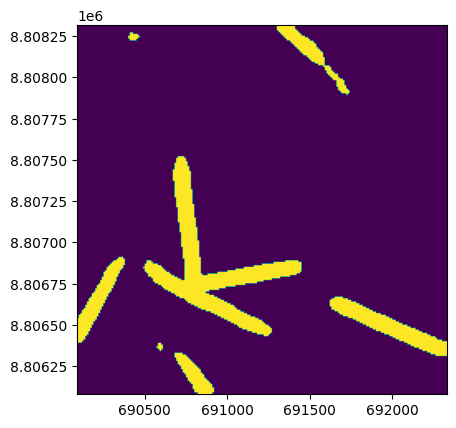

Prediction mosaic saved to: prediction_mosaic.tif


In [56]:
# 1. Collect prediction file paths from the tiles GeoDataFrame
prediction_files = tiles['prediction_file'].tolist()

# 2. Open prediction rasters using rasterio
prediction_datasets = [rasterio.open(file) for file in prediction_files]

# 3. Merge prediction rasters into a single array
mosaic, out_transform = merge(prediction_datasets)

# 4. Update metadata for the mosaic
out_meta = prediction_datasets[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "count": 1  # Single band for predictions
})

# 5. Save the mosaic as a GeoTIFF file
output_mosaic_file = "prediction_mosaic.tif"
with rasterio.open(output_mosaic_file, "w", **out_meta) as dest:
    dest.write(mosaic)

# 6. (Optional) Visualize the mosaic
show(mosaic, transform=out_transform)

print(f"Prediction mosaic saved to: {output_mosaic_file}")

## Visualize Predictions on the satellite image

In [79]:
image = rio.open(tif_file)
predictions = rio.open(output_mosaic_file)

# Read the predictions data
pred_data = predictions.read(1)  # Read the first band

# Create a mask where only pixels with a value of 1 are kept
masked_pred_data = np.ma.masked_where(pred_data != 1, pred_data)

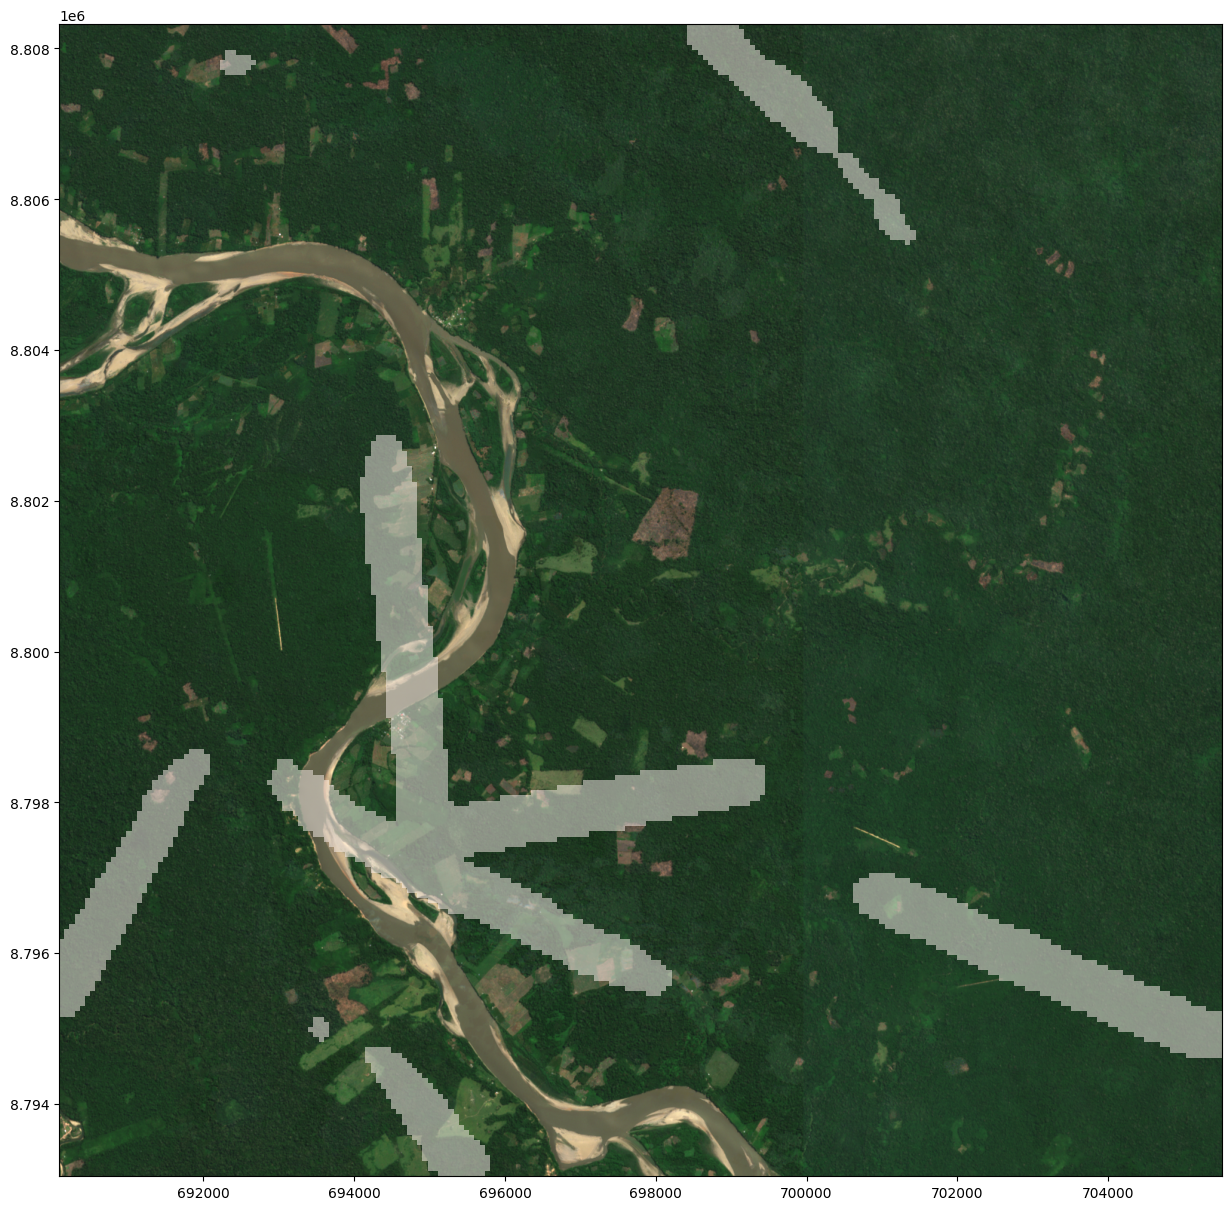

In [93]:
fig, ax = plt.subplots(figsize=(15, 15))

# Display the base image using imshow
show(image, ax=ax, cmap='gray')  # Adjust cmap if needed

# Get the extent of the image
image_extent = ax.get_images()[0].get_extent()

# Display the masked prediction data with transparency on top
show(
    masked_pred_data,
    ax=ax,
    alpha=0.5,
    cmap="Reds",
    extent=image_extent  # Use the image extent for proper alignment
)

plt.show()